# Decision Trees and the Random Forest Classifier  

## Decision Trees

A decision tree algorithm is a classifier that infers class labels by sub-dividing the data set until the decision can be reached. The algorithm starts at the tree root and splits the data on the feature that results in the largest information gain (IG). This process is repeated at each child node until the leaves are pure. The quest for purity decision trees can lead to many nodes, which in turn results in overfitting. Consequently, a common practice is to prune the tree by setting a limit for the maximmum depth of a tree.  

The objective function that is optimized by the tree learning algorithm is the information gain (IG) at each split, which is defined by the following:
![alt](extras/IG.PNG)
Here, f is the feature to perform the split, Dp and Dj are the datasets of the parent and the jth child node, I is our impurity measure, Np is the total number of samples at the parent node, and Nj is the number of samples in the jth child node. Looking at the equation, we can see the higher the impurity of the parent node and the lower the impurity of the child nodes, the larger the information gain. Most libraries, including scikit-learn, implement binary decision trees, which simplies the IG equation to:
![alt](extras/IG2.PNG)
Our three main impurity measures, or splitting criteria, are entropy, Gini index, and classfication error. Entropy is defined by:
![alt](extras/Entropy.PNG)
where p(i|t) is the proportion of the samples that belongs to class c for a particular node t. The entropy is thus zero if all the samples at a node belong to same class, and likewise entropy is maximized (1) when we have a uniform class distribution. The Gini index attempts to minimize the probability of misclassfication:
![alt](extras/GiniIndex.PNG)
Lastly, the classificaion error is:
![alt](extras/ClassificationError.PNG)

#### Understanding the relationship between the impurity measures
From the chart below, we can see that the Gini index is a compromise between entropy and the classification error.

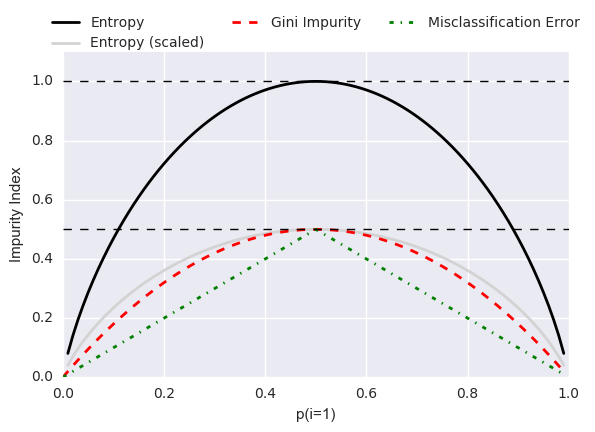

In [35]:
def gini(p):
    return 1-(p**2 + (1-p)**2)


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

## Decision Tree code example

Import standard libraries.

In [4]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Load the iris data set.

In [7]:
iris = datasets.load_iris()
y = iris.target
X = pd.DataFrame(iris['data'], columns=['sepal length', 'sepal width', 'petal length', 'petal width'])

Split the data into test and training sets.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Run the decision tree classifier from sklearn, pruning the tree so that the maximum depth is at `max_depth=3`, and using entropy as our measure of impurity.

In [18]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Predict the test set labels and evaluate the model. We can see that the model does a good job of predicting the target labels.

In [19]:
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       1.00      0.93      0.97        15
          2       0.94      1.00      0.97        16

avg / total       0.98      0.98      0.98        45

[[14  0  0]
 [ 0 14  1]
 [ 0  0 16]]


We can visualize our decision tree classifier using the following code:

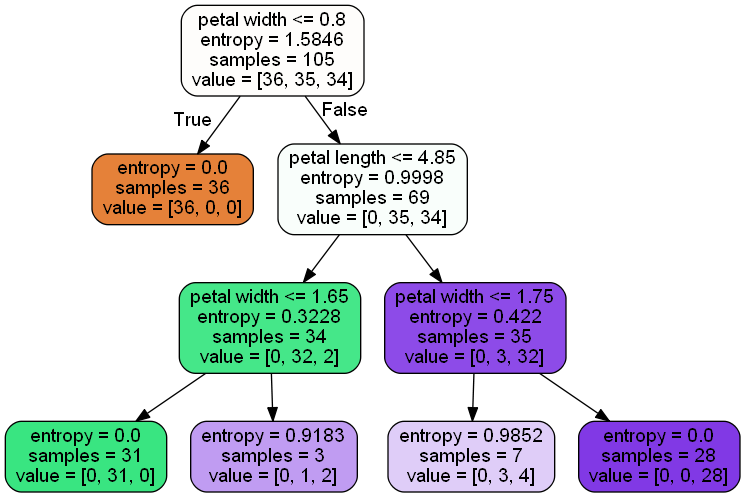

In [20]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = X_train.columns

dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

## Random Forest Classifier

The random forest classifier is an ensemble of decision trees, meaning it combines weak learners to build a more robust model - a strong learner - that has a better generalization and is less susceptible to overfitting. The four primary steps of the algorithm are:
1. Draw a random bootstrap sample of size n, meaning randomly choose n samples from the training set with replacement. 
2. Grow a decision tree from the bootsrap sample. At each node:
    1. Randomly select d features without replacement.
    2. Split the node using the feature that provides the best split according to the objective function - typically the information gain.
3. Repeat steps 1 and 2 k times.
4. Aggregate the prediction by each tree to assign the class label by majority vote.  

Step 2A is sometimes called "feature bagging." The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the trees, causing them to become correlated.

Random forests make it difficult to interpret the relationship between the features and the classification. However, what we lose in interpretability, we gain in simplicity: we don't have to worry much about choosing good hyperparameter values or pruning the forest, since the model is robust to noise from individual decision trees. The primary parameter that we need to choose is the number of trees; generally, the number of trees increases model performance but also the computational cost. Increasing the size n of the bootstrap sample will decrease the randomness and thus increase the
likelihood to overfit. Smaller sizes of n will reduce overfitting but at the expense of model performance. In scikit-learn, the size of the bootstrap sample is equal to the number of samples in the original training set, resulting in a good bias-variance tradeoff. For the number of features d at each split, the default used in scikit learn is d = m^(1/2).

Because the bootstrap aggregating method results in unused samples in each tree, this allows us to get the out-of-bag error (oob) from these unused samples, giving us an unbiased estimate of the test set error. 

## Random Forest code example
We will choose entropy as our impurity measure that helps us maximize the information gain. The n_estimators parameter controls the number of trees that we run. Setting `oob_score=True` will allow us to see the out-of-bag accuracy. 

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=100,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

Let's take a look at our out-of-bag score.

In [30]:
print "%.2f" % forest.oob_score_ 

0.92


Looking at our model performance on the test data set, we can see that the model actually correctly predicted all of the target labels. 

In [24]:
predictions = forest.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[14  0  0]
 [ 0 15  0]
 [ 0  0 16]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        45



## Additional Resources

- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://en.wikipedia.org/wiki/Random_forest
- https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm